In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

In [44]:
warnings.simplefilter('ignore')
df = pd.read_csv('Cleaned Datasets/US_Full_Quarterly.csv', index_col="DATE")
#df.index.rename("Date", inplace=True)
#
deflator = pd.read_csv("Cleaned Datasets/GDPDEF.csv",index_col = "DATE")
df = df.join(deflator,on = "DATE", how = "inner")
df["Real GDP"] = df["GDP"]/df["GDPDEF"]
df["Real Inv"] = df["Inv"]/df["GDPDEF"]
df.index = pd.to_datetime(df.index)


USA = df[['Real GDP']]
USA['log_GDP'] = np.log(USA['Real GDP'])
USA

,Real GDP,log_GDP
DATE,,
1947-01-01,21.826048,3.083104
1947-04-01,21.769006,3.080487
1947-07-01,21.723823,3.078409
1947-10-01,22.064645,3.093977
1948-01-01,22.397134,3.108933
...,...,...
2022-10-01,219.899619,5.393171
2023-01-01,221.123040,5.398719
2023-04-01,222.254258,5.403822


# Classical Decomposition - Multiplicative model

We begin with a preliminary analysis of GDP trends using a classical decomposition model. 

The figure below shows the GDP trends of the United States in every quarter from 1947-2023.

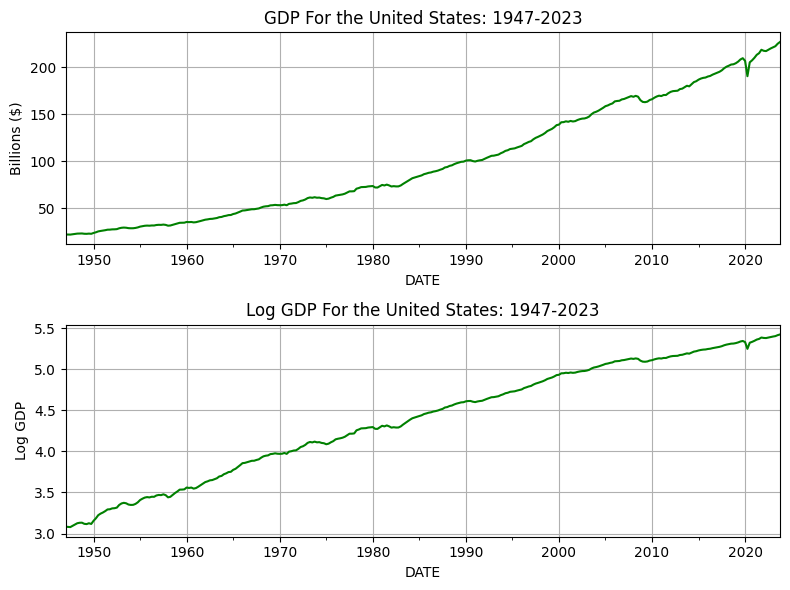

In [47]:
# Plot initial results
fig, axs = plt.subplots(2,1, figsize=(8,6))
plt.gca().yaxis.get_offset_text().set_visible(False)
USA.plot(y="Real GDP", ax=axs[0], use_index=True, legend=False, color="green")
#JAPAN.plot(x="Year", y="GDP", ax=axs[0], label="Japan")
axs[0].set_title("GDP For the United States: 1947-2023")
axs[0].set_ylabel("Billions ($)")
axs[0].grid()

# Plot the logged models
USA.plot(y="log_GDP", ax=axs[1], use_index=True, legend=False, color='green')
axs[1].set_title("Log GDP For the United States: 1947-2023")
axs[1].grid()
axs[1].set_ylabel("Log GDP")
plt.gca().yaxis.get_offset_text().set_visible(False)
#plt.suptitle("Figure GDPFIGURE")
plt.tight_layout()
plt.savefig("V3_GDP.png", dpi=300)
plt.show()

Since GDP generally grows exponentially (see figure GDPFIGURE), we will take the natural log of GDP to get our model into the following additive form:

EXPONENTIALITY SOUCE: https://www.sciencedirect.com/science/article/pii/S0921800917312326#fn0005

$$ Z_t = T_t + S_t + R_t $$

In this model, $Z_t$ represents log GDP, $T_t$ represents the trend, $S_t$ represents a seasonal component, and $R_t$ is the remainder. If the decomposition model accurately described the data and our choices of $T_t$ and $S_t$ are correct, we would anticipate that $R_t$ is covariance-stationary.


The log GDP graph is approximately linear, indicating that the trend $T_t$ should be of the form $T_t = \beta_1 t + \beta_0 $. The seasonal component $S_t$ doesn't appear significant in this graph, so we will assume $ S_t = 0 $. 

Since there isn't a seasonality aspect to this data, a moving averages model will not help us estimate the trend $T_t$. However, running a simple linear regression on the data can help us estimate the parameters $ \hat{\beta_0}, \hat{\beta_1}$. Using these parameters, we will difference the data in our model to see whether the differenced data is covariance-stationary; if it is, we can be confident that our model adequately explains the variation in the data.

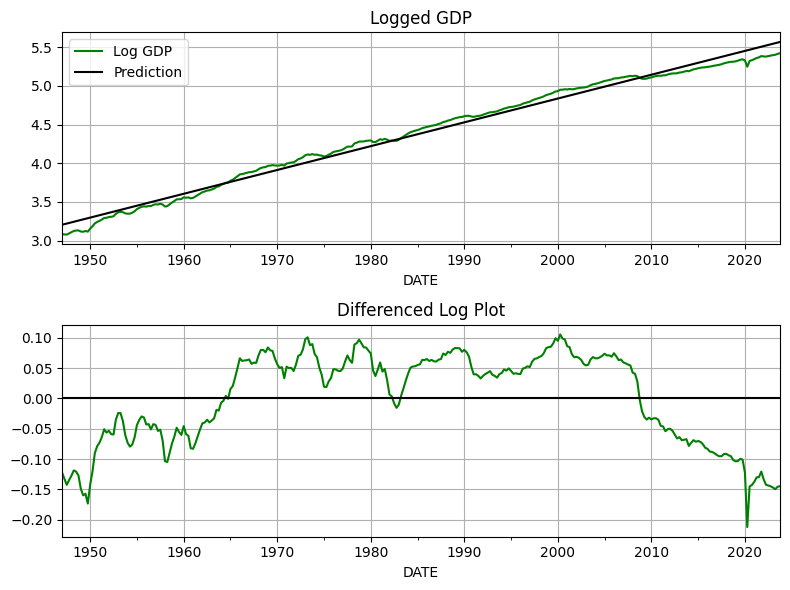

beta_0: 3.2056
beta_1: 0.0077


In [48]:
def FitTrendAndPlot(df):
    '''df - the dataframe of the country data'''
    y = df[['log_GDP']].reset_index(drop=True)
    X = sm.add_constant(y.index)
    model = sm.OLS(y, X).fit()
    modelPrediction = model.predict(X)
    df['ModelPrediction'] = modelPrediction

    # Plot the results, both logged and the original
    fig, axs = plt.subplots(2,1, figsize=(8,6))
    df.plot(y='log_GDP', ax=axs[0], color='green', label="Log GDP", use_index=True)
    df.plot(y='ModelPrediction', ax=axs[0], label="Prediction", color="black", use_index=True)
    axs[0].set_title(f"Logged GDP")
    axs[0].grid()
    axs[0].legend()

    # De-trend the plots
    df['detrended_log_GDP'] = df['log_GDP'] - modelPrediction
    df.plot(y='detrended_log_GDP', ax=axs[1], legend=False, use_index=True, color='green')
    axs[1].plot(df.index, np.zeros(len(df.index)), 'k-')
    axs[1].set_title("Differenced Log Plot")
    axs[1].grid()
    
    plt.tight_layout()
    plt.savefig("V3_Decomp.png", dpi=300)
    plt.show()

    return model

modelUSA = FitTrendAndPlot(USA)
print(f"beta_0: {modelUSA.params[0].round(4)}")
print(f"beta_1: {modelUSA.params[1].round(4)}")

The differenced plot on the right represents the log GDP growth. The United States experienced smaller growth than normal up until the mid-1970s, overperformed until the mid-2000s, then began to underperform again. It is clear that this differenced data is not covariance-stationary: the expected values are dependent on time. This implies that the multiplicative decomposition model is inadequate to model GDP growth. There is clearly significant variation that is not explained by the model. As such, we will turn our focus to ARMA models and Kalman filtering to better understand GDP trends.